In [1]:
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
class hp:
    def M_H2_calculation(galaxy, reg):
        # Required constants
        L_CO = 3.25*(10**7)
        L_10 = 2
        M_H2_const = 5
        if reg == 1:
            M_H2 = M_H2_const*L_CO * \
                galaxy['flux_0']*(galaxy['freq_f']**(-2)) * \
                (galaxy['d']**2)*((1+galaxy['z'])**(-3))
            M_H2_cent_er = galaxy['flux_0_er']/galaxy['flux_0']
            galaxy.update({'M_H2_0': M_H2, 'M_H2_0_er': M_H2_cent_er})
        else:
            print('Some mistake')
            exit()
        return galaxy

    def SFR_calculation(galaxy, reg):
        alpha = 0.75  # synchrotron spectral index
        fnth = 1  # Galactic normalization
        beta = 1.35  # dust emmisivity index
        temp = galaxy['Td']  # temp of cold dust
        e = 2.7182818284  # Euler number
        chabrier = 1.8 # chabrier IMF, correction
        nu_0 = (1+galaxy['z'])*galaxy['freq_c']

        tail = 25*fnth*(nu_0**(-1*alpha)) + 0.71*(nu_0**(-0.1)) + (1.5*(10**(-6))*(nu_0**3)*(
            1 - e**((-1)*((nu_0/2000)**beta))))/((e**(0.048*nu_0/temp)) - 1)

        if reg == 1:
            SFR = galaxy['flux_0_c']*(galaxy['d']**2)/(chabrier*(1+galaxy['z'])*tail)
            SFR_cent_er = galaxy['flux_0_c_er']/galaxy['flux_0_c']
            galaxy.update(
                {'SFR_0': SFR, 'SFR_0_er': SFR_cent_er})
        else:
            print('Some mistake')
            exit()
        return galaxy
    
    def size(galaxy):
        d = galaxy['d']
        res = [hp.kpc(d, galaxy['ConMaj_0'], galaxy['ConMaj_0_er']), hp.kpc(d, galaxy['ConMin_0'], galaxy['ConMin_0_er'])]
        res.extend([hp.kpc(d, galaxy['ConMaj_1'], galaxy['ConMaj_1_er']), hp.kpc(d, galaxy['ConMin_1'], galaxy['ConMin_1_er'])])
        return res

    def kpc(dist, angle, angle_er):
        return np.pi*dist*angle*1000/(180*3600), np.pi*dist*angle_er*1000/(180*3600)
    
    def log_er(item):
        return [[abs(math.log(1-item, 10))], [abs(math.log(1+item, 10))]]
    
    def log(point):
        return math.log(point, 10)

In [3]:
class Main(hp):
    
    def __init__(self, file_name):
        self.file_name = file_name  # database in csv format

        self.data = []  # transferring database

    def json_reader(self):
        f = open(self.file_name)
        self.data = json.load(f)
        f.close()

    def calculation(self):
        for galaxy in self.data:
            galaxy.update({'M_H2_er2' : galaxy['M_H2_er']/galaxy['M_H2']})
            galaxy.update({'SFR_er' : 0.3})
            galaxy.update({'SFR_10' : 10**galaxy['SFR']})
            galaxy.update({'SFR_10_er' : 10**galaxy['SFR']*0.3})
            if galaxy['flux_0'] > 0:
                galaxy = hp.M_H2_calculation(galaxy, 1)
            if galaxy['flux_0_c'] > 0:
                galaxy = hp.SFR_calculation(galaxy, 1)
            #print(f'{galaxy}\n\n')
            
    def plotting_SFR(self):
        fig = plt.figure()
        ax = fig.add_subplot()

        for galaxy in self.data:
            if galaxy['flux_0_c'] > 0:
                ax.errorbar(galaxy['SFR_0'], galaxy['SFR_10'], xerr=galaxy['SFR_0_er']*galaxy['SFR_0'],
                    yerr=galaxy['SFR_10_er'], fmt='o', color='r')
                ax.text(galaxy['SFR_0'], galaxy['SFR_10'], str(galaxy['index']))
        ax.plot([0, 40], [0, 40], 'g--')
        ax.set_xlim([0,40])
        ax.set_ylim([0,40])
        ax.set_xlabel('SFR_CALCULATED, M/yr')
        ax.set_ylabel('SFR_SED_model, M/yr')
        plt.savefig('SFR5.png')
        plt.show()
    
    def plotting_M_H2(self):
        fig = plt.figure()
        ax = fig.add_subplot()

        M_H2_func = np.arange(7, 12, 0.05, dtype=float)

        for galaxy in self.data:
            if galaxy['flux_0_c'] > 0 and galaxy['flux_0'] > 0:
                ax.errorbar(hp.log(galaxy['M_H2_0']), hp.log(galaxy['SFR_0']), xerr=hp.log_er(galaxy['M_H2_0_er']),
                    yerr=hp.log_er(galaxy['SFR_0_er']),fmt='o', color='r')
                ax.text( hp.log(galaxy['M_H2_0']), hp.log(galaxy['SFR_0']), str(galaxy['index']))
            
            ax.errorbar(hp.log(galaxy['M_H2']), galaxy['SFR'], xerr=hp.log_er(galaxy['M_H2_er2']), yerr=hp.log_er(galaxy['SFR_er']),
                    fmt='o', color='c')
            ax.text(hp.log(galaxy['M_H2']), galaxy['SFR'], str(galaxy['index']))
        
        ax.errorbar(-99.9,-99.9, xerr=0, yerr=0, label='Calculated', fmt='o', color='r')
        ax.errorbar(-99.9,-99.9, xerr=0, yerr=0, label='SED-model', fmt='o', color='c')
            
        ax.plot(M_H2_func, 0.95*M_H2_func - 8.57,
                 'g--', label='Function for normal galaxies (ARTICLE)')
        ax.set_xlim([7, 11])
        ax.set_ylim([-2.2, 2.2])
        ax.set_xlabel('log(M_H2), M/yr')
        ax.set_ylabel('log(SFR), M/yr')
        plt.savefig('MH2_vs_SFR3_4.png')
        plt.show()
    
    def plotting_age_mdms(self):
        fig = plt.figure()
        ax = fig.add_subplot()
        for galaxy in self.data:
            ax.scatter(galaxy['age'], galaxy['mdms'], color='c')
            ax.text(galaxy['age'], galaxy['mdms'], str(galaxy['index']))
        
        x = np.arange(8.8, 10, 0.01)
        ax.plot(x, (-1)*((10**x)/((10**9)*5.8)) - 2.41, 'g--')
        #ax.set_xlim([8.8, 10])
        #ax.set_ylim([-3.5, -2.5])
        ax.set_xlabel('log(age), yr')
        ax.set_ylabel('log(Md/Ms), 1')
        plt.savefig('age_mdms.png')
        plt.show()
    
    def calculating_size(self):
        for galaxy in self.data:
            if galaxy['index'] <= 3:
                print(f"{galaxy['index']}")
                res = hp.size(galaxy)
                print(f"Maj0 {res[0][0]} +- {res[0][1]}")
                print(f"Min0 {res[1][0]} +- {res[1][1]}")
                print(f"Maj1 {res[2][0]} +- {res[2][1]}")
                print(f"Min1 {res[3][0]} +- {res[3][1]}")
                print('\n')

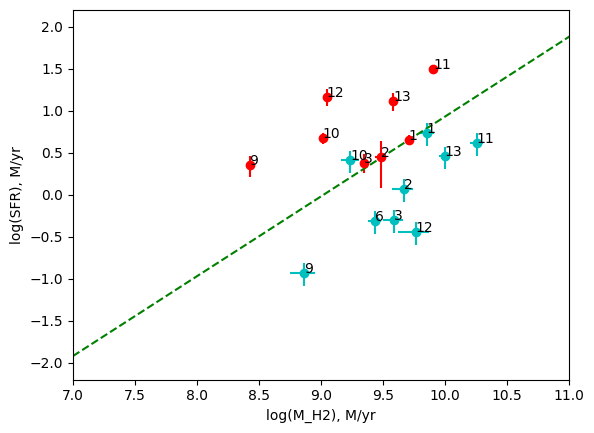

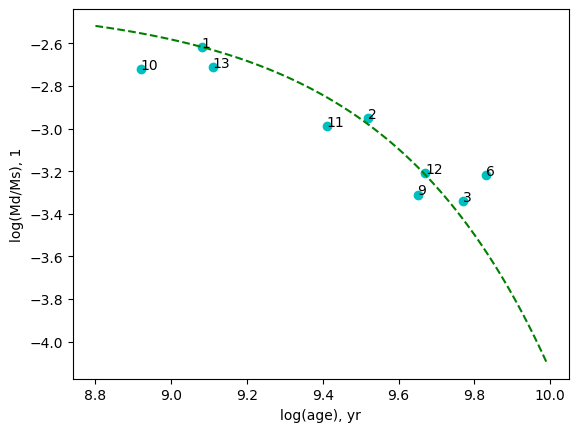

1
Maj0 2.0696778702554828 +- 0.024931296214888665
Min0 2.054682115820524 +- 0.02461553365246636
Maj1 1.7791987322766123 +- 0.03853656121479522
Min1 1.4961103197338064 +- 0.02733494695544386


2
Maj0 5.478681075275423 +- 0.4787206835289767
Min0 2.8384566677443557 +- 0.205545229294797
Maj1 1.2539898232022901 +- 0.1623270287356973
Min1 1.2031025229537275 +- 0.14794072274413178


3
Maj0 3.0803005919984376 +- 0.16163688671061582
Min0 2.142024991025224 +- 0.09271846495817346
Maj1 1.9729632918856772 +- 0.07785748695024176
Min1 1.4249606656101321 +- 0.0417899535937585




In [4]:
if __name__ == '__main__':
    obj = Main('RGupd.json')
    obj.json_reader()
    obj.calculation()
    obj.plotting_SFR()
    obj.plotting_M_H2()
    obj.plotting_age_mdms()
    obj.calculating_size()